<a href="https://colab.research.google.com/github/addo561/DDPM/blob/main/DDPM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -q diffuser lightning

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 58.0 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from typing import Tuple,Optional
import lightning as pl

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu") cooment out for inference
device = torch.device('cpu')
print(f"Using device: {device}")


Using device: cpu


In [ ]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5),(0.5))

])

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 496kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.95MB/s]


Input shape: torch.Size([128, 1, 28, 28])
Labels: tensor([3, 5, 6, 6, 2, 5, 2, 1, 1, 9, 0, 0, 6, 2, 6, 2, 3, 2, 4, 2, 5, 2, 9, 4,
        8, 9, 9, 8, 6, 3, 9, 4, 5, 3, 1, 3, 1, 3, 1, 5, 0, 5, 0, 0, 4, 4, 4, 7,
        4, 1, 1, 4, 1, 7, 3, 7, 5, 7, 1, 7, 6, 7, 4, 7, 9, 2, 0, 8, 8, 9, 6, 8,
        6, 7, 1, 6, 8, 0, 5, 2, 4, 6, 6, 4, 8, 0, 1, 7, 8, 7, 2, 3, 1, 1, 7, 1,
        2, 1, 0, 5, 6, 2, 2, 8, 7, 4, 6, 3, 3, 2, 7, 1, 1, 4, 0, 9, 3, 4, 8, 0,
        6, 8, 6, 3, 1, 7, 1, 2])


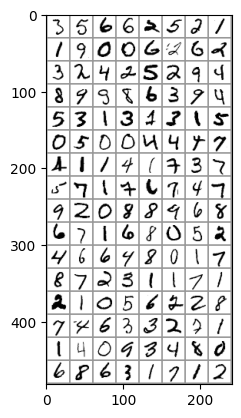

In [ ]:
dataset = torchvision.datasets.MNIST(
    root="mnist/", train=True, download=True, transform=transforms
)
train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
x, y = next(iter(train_dataloader))
print("Input shape:", x.shape)
print("Labels:", y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

Denoising Diffusion Probabilistic Models (DDPM).
- `Main aim`  - we get an image from data and add noise step by step. Then We train a model to predict that noise at each step and use the model to generate images.


In [ ]:
class Diffusion(nn.Module):
  def __init__(self,model: nn.Module,n_steps : int,device:torch.device):
    super().__init__()
    #unet model
    self.model = model
    self.n_steps = n_steps  #T  steps
    beta = torch.linspace(0.0001,0.02,n_steps).to(device) #linearly increasing variance schedule
    self.register_buffer('beta',beta)

    alpha = 1. - self.beta
    self.register_buffer('alpha', alpha)
    alphacum = torch.cumprod(self.alpha,dim=0)
    self.register_buffer('alphacum', alphacum)


    self.sigma2 = self.beta
    self.device = device


  def gather(self,const:torch.Tensor,t:torch.Tensor):
    '''Gather consts for t and reshape to feature map shape'''
    c = const[t]
    return c.reshape(-1,1,1,1)

  def q_xt_x0(self,x0:torch.Tensor,t:torch.Tensor)-> Tuple[torch.Tensor,torch.Tensor]:
    '''Forward distribution definition which returns mean and var that describes it '''
    #put corresponding alpha along t in a  batch
    mean = self.gather(self.alphacum,t) ** 0.5 * x0
    var = 1 - self.gather(self.alphacum,t)
    return mean,var

  def q_sample(self,x0:torch.Tensor,t:torch.Tensor,eps:Optional[torch.Tensor]=None):
    '''sample from q_xt_x0- forward process'''
    if eps is None:
      eps = torch.randn_like(x0)# pure noise
    mean,var = self.q_xt_x0(x0,t)
    return  mean + (var**0.5) * eps # computing for next  image with  a little  noise

  def p_sample(self,xt: torch.Tensor,t:torch.Tensor):
    '''for reverse sampling '''
    #prediction
    eps_pred = self.model(xt,t).sample
    #get constants
    alpha_bar = self.gather(self.alphacum,t)
    alpha = self.gather(self.alpha,t)
    #mean
    eps_coeff = (1-alpha)/(1-alpha_bar)**0.5
    mean = 1/(alpha**0.5)  *  (xt - eps_coeff*eps_pred)
    #variance
    var   = self.gather(self.sigma2,t)
    #noise
    eps = torch.randn_like(xt)
    mask = (t>0).float().reshape(-1,1,1,1)
    return mean + (var ** 0.5) *  eps * mask

  def loss(self,x0:torch.Tensor,noise : Optional[torch.Tensor]=None):
    '''Simpified loss'''
    b = x0.shape[0]
    t =  torch.randint(0,self.n_steps,(b,),device=x0.device,dtype=torch.long)
    if noise is None:
      noise  = torch.randn_like(x0)
    xt = self.q_sample(x0,t,eps=noise)
    #predict noise
    eps_theta = self.model(xt,t).sample
    return F.mse_loss(noise, eps_theta)



In [ ]:
# Create the network
net = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
net.to(device)

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

In [ ]:
class DDPM(pl.LightningModule):
    def __init__(self):
      super().__init__()
      #unet model for noise prediction
      self.model = net
      #diffusion class, contains forward and reverse methods for denoising and destroying image with noise
      self.diffusion = Diffusion(model=net,n_steps=1000,device=device)

    def training_step(self, batch, batch_idx):
      # Unpacking images
      images,_ = batch
      loss = self.diffusion.loss(images)
      return loss # get loss

    def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
      return optimizer

    def forward(self,num_samples):
      device = self.device
      self.eval()
      xt = torch.randn(size=(num_samples,1,28,28),device=device)
      for t in reversed(range(0,1000)):
        tensor_t = torch.full((num_samples,),t,device=device).long()
        xt =  self.diffusion.p_sample(xt,tensor_t)
      return xt

In [ ]:
#ImageSampler callback
class ImageSampler(pl.Callback):
  def __init__(self):
        super().__init__()
        self.xt = torch.randn(size=(4,1,28,28))
  def on_train_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule"):
    # Turn off gradients
    diffusion = Diffusion(pl_module.model,1000,device=pl_module.device)
    pl_module.eval()

    # Don't need gradients for sampling
    with torch.no_grad():
      xt = self.xt.to(pl_module.device).clone()
      for t in range(999,-1,-1):
        t_tensor = torch.full((4,),t,device=pl_module.device).long()
        xt = diffusion.p_sample(xt,t_tensor)
        if t%200==0 or t==999:
          img = xt.clone().clamp(-1,1)
          img = (img +1)/2
          grid = torchvision.utils.make_grid(img)
          plt.figure(figsize=(4, 4))
          plt.imshow(grid.cpu().numpy().transpose(1, 2, 0))
          plt.title(f'step [{t}] ,epoch {trainer.current_epoch}')
          plt.axis('off')
          plt.show()
          plt.close()
      xt = xt.clamp(-1,1)
      xt = (xt +1)/2
      grid = torchvision.utils.make_grid(xt)
      plt.figure(figsize=(8, 8))
      plt.imshow(grid.cpu().numpy().transpose(1, 2, 0))
      plt.title(f'sample after epoch {trainer.current_epoch}')
      plt.axis('off')
      plt.show()
      plt.close()

    pl_module.train()

In [ ]:
ddpm = DDPM()
trainer = pl.Trainer(callbacks=[ImageSampler()], accelerator='cpu', max_epochs=10)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/setup.py:175: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type        ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ UNet2DModel │  1.7 M │ train │     0 │
│ 1 │ diffusion │ Diffusion   │  1.7 M │ train │     0 │
└───┴───────────┴─────────────┴────────┴───────┴───────┘

Trainable params: 1.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.7 M                                                                                                
Total estimated model params size (MB): 6                                                                          
Modules in train mode: 278                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

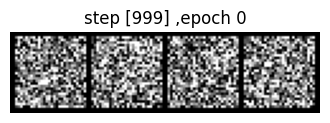

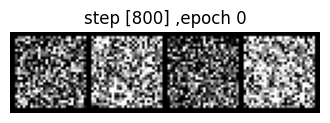

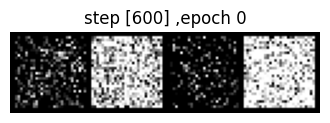

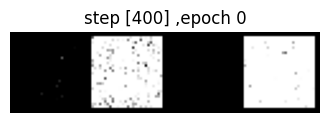

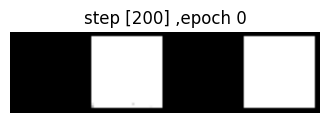

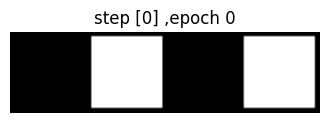

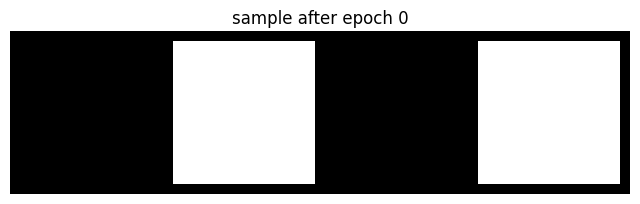

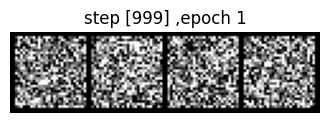

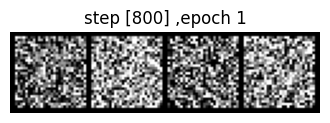

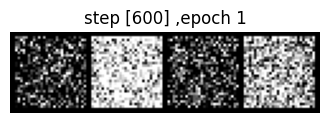

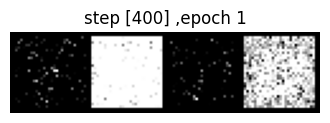

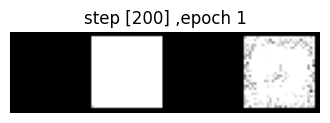

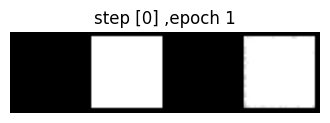

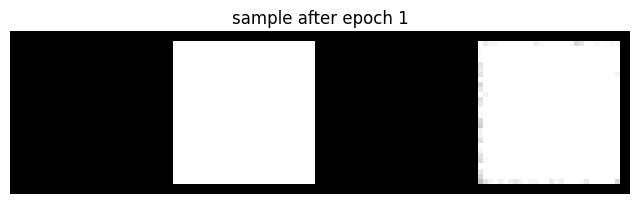

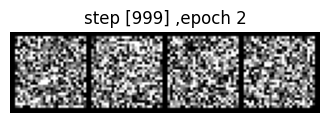

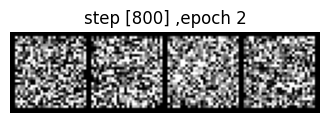

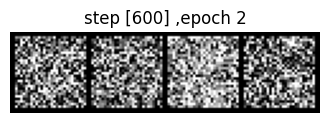

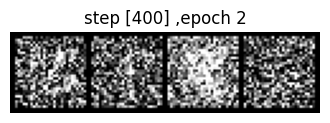

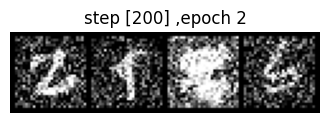

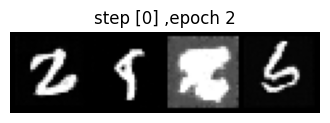

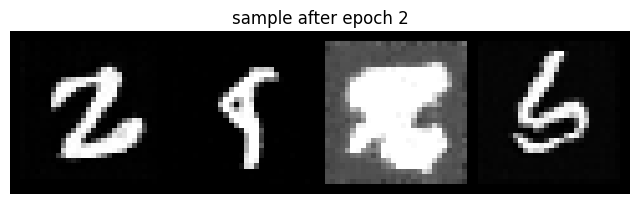

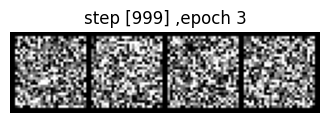

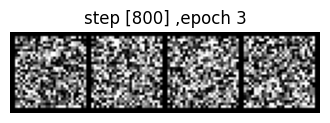

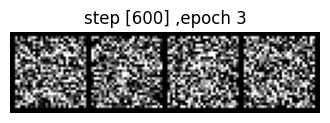

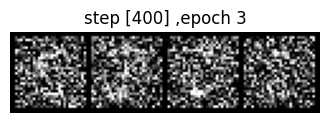

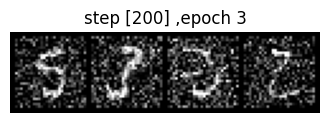

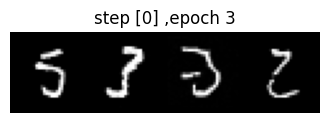

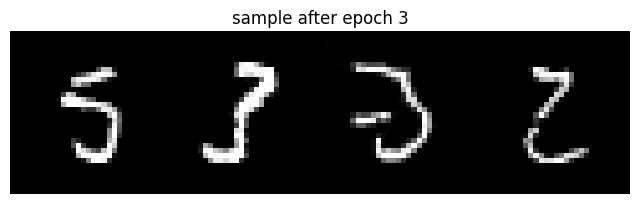

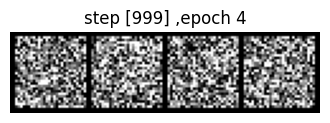

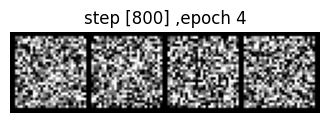

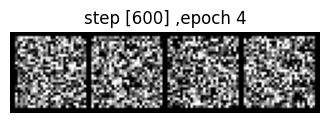

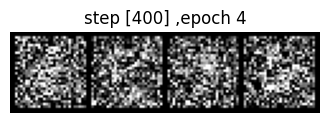

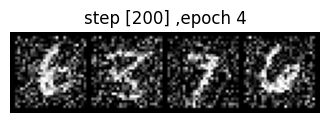

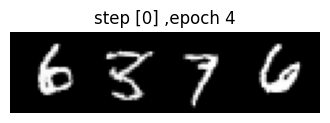

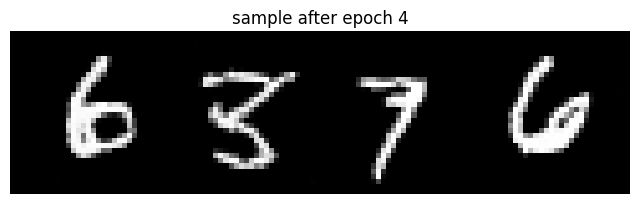

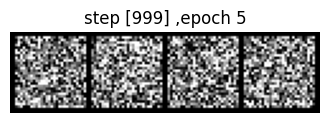

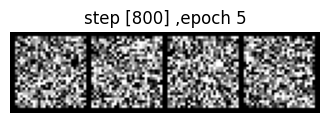

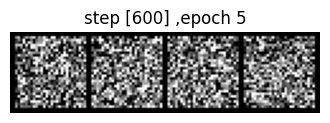

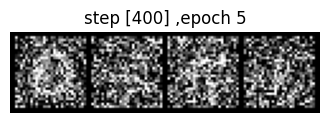

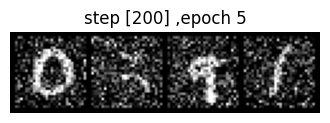

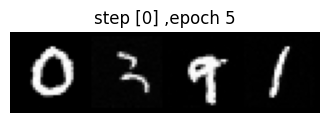

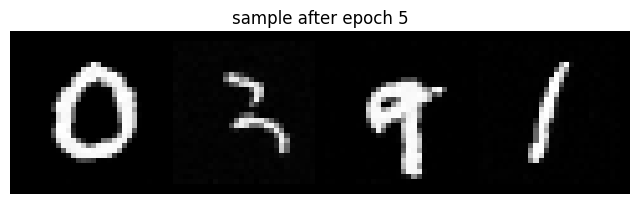

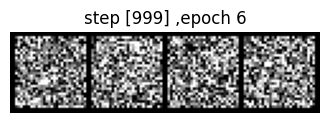

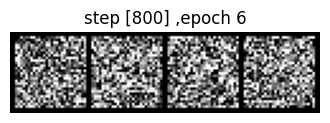

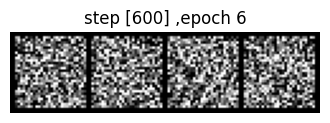

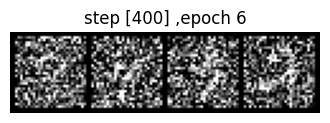

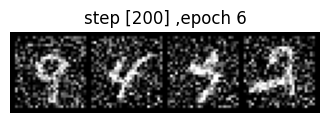

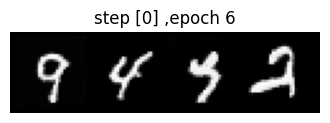

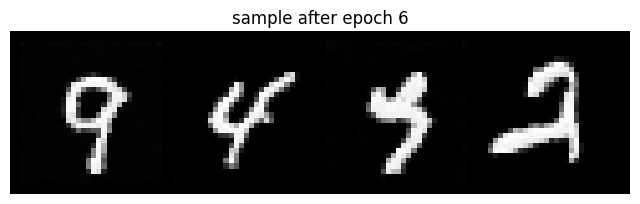

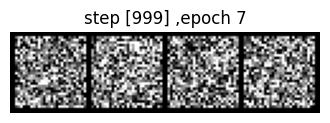

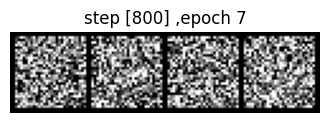

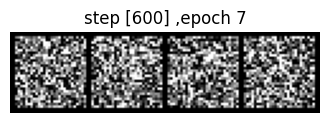

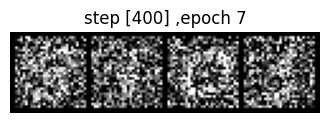

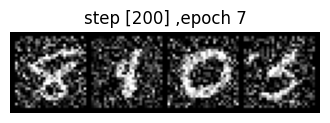

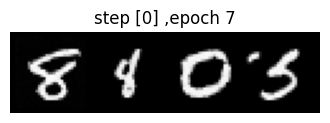

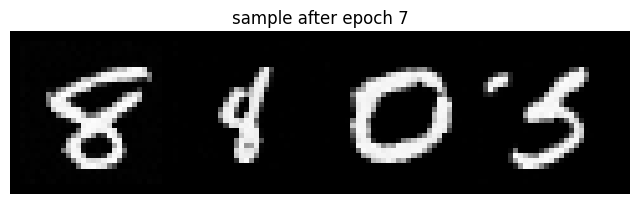

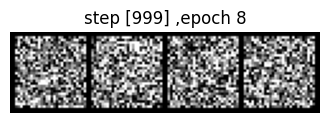

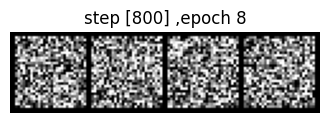

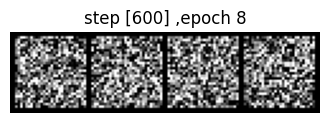

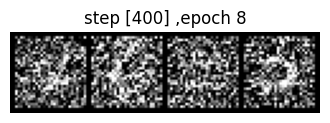

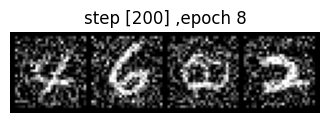

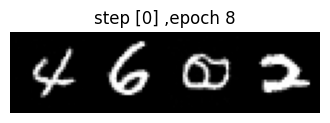

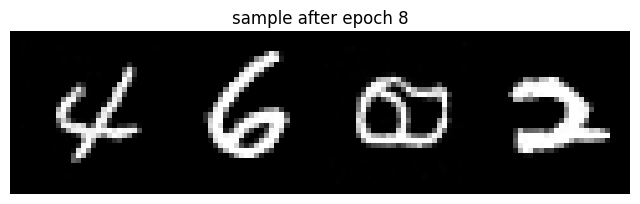

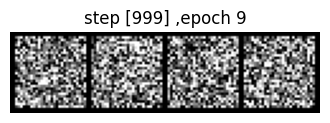

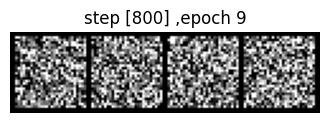

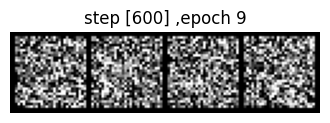

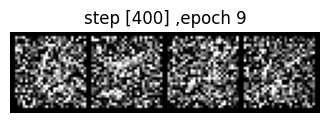

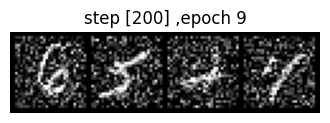

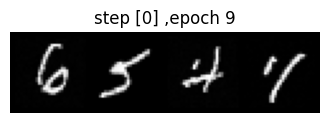

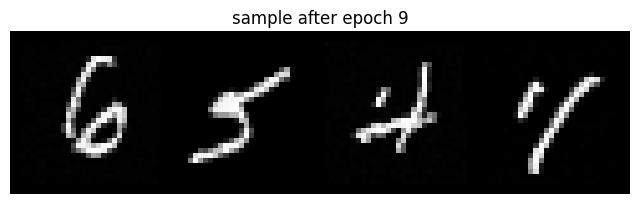

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
trainer.fit(model=ddpm,train_dataloaders=train_dataloader)

In [ ]:
torch.cuda.empty_cache() # Clear CUDA cache
ddpm = ddpm.cpu()
xt = ddpm(num_samples=4)
xt = xt.clamp(-1,1).cpu()
xt = (xt+1)/2
grid = torchvision.utils.make_grid(xt)
plt.imshow(grid.detach().cpu().numpy().transpose(1,2,0))
plt.title('Generated Images')
plt.axis('off')
plt.show()